## 0. 参数配置

In [6]:
import os
import sys
import shutil
BASE_DIR = os.getcwd()
sys.path.append(os.path.join(BASE_DIR, '..'))
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from nets.unet import Unet
from nets.unet_training import CE, Generator, LossHistory
from utils.metrics import f_score

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
def get_train_step_fn():
    @tf.function
    def train_step(images, labels, net, optimizer, loss):
        with tf.GradientTape() as tape:
            # 计算loss
            prediction = net(images, training=True)
            # print("loss input: {} {}".format(labels.shape, prediction.shape))
            loss_value = loss(labels, prediction)

        grads = tape.gradient(loss_value, net.trainable_variables)
        optimizer.apply_gradients(zip(grads, net.trainable_variables))
        
        _f_score = f_score()(labels, prediction)
        return loss_value, _f_score
    return train_step


@tf.function
def val_step(images, labels, net, loss):
    # 计算loss
    prediction = net(images, training=False)
    loss_value = loss(labels, prediction)
    
    _f_score = f_score()(labels, prediction)
    return loss_value, _f_score


def fit_one_epoch(net, loss, optimizer, epoch, epoch_size, epoch_size_val, gen, genval, Epoch, train_step):
    total_loss = 0
    total_f_score = 0

    val_loss = 0
    val_f_score = 0
    with tqdm(total=epoch_size,desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_size:
                break
            images, labels = batch[0], batch[1]
            labels = tf.cast(tf.convert_to_tensor(labels), tf.float32)

            loss_value, _f_score = train_step(images, labels, net, optimizer, loss)
            total_loss += loss_value.numpy()
            total_f_score += _f_score.numpy()

            pbar.set_postfix(**{'Total Loss'        : total_loss / (iteration + 1), 
                                'Total f_score'     : total_f_score / (iteration + 1),
                                'lr'                : optimizer._decayed_lr(tf.float32).numpy()})
            pbar.update(1)
        
    print('Start Validation')
    with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(genval):
            if iteration>=epoch_size_val:
                break
            images, labels = batch[0], batch[1]
            labels = tf.convert_to_tensor(labels)

            loss_value, _f_score = val_step(images, labels, net, loss)
            val_loss            += loss_value.numpy()
            val_f_score         += _f_score.numpy()

            pbar.set_postfix(**{'Val Loss'      : val_loss / (iteration + 1), 
                                'Val f_score'   : val_f_score / (iteration + 1)})
            pbar.update(1)

    logs = {'loss': total_loss/(epoch_size+1), 'val_loss': val_loss/(epoch_size_val+1)}
    loss_history.on_epoch_end([], logs)
    print('Finish Validation')
    print('Epoch:' + str(epoch+1) + '/' + str(Epoch))
    print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1),val_loss/(epoch_size_val+1)))

In [8]:
# step0：参数配置
# dataset_path = r"G:\deep_learning_data\EG_dataset\voc_format"  # local 
dataset_path = os.path.join(BASE_DIR, "..", "data", "dataset", "voc_format")  #  linux 
model_path = os.path.join(BASE_DIR, "data", "model_data", "unet_voc.h5") # 预训练模型

max_epoch = 100  # 总迭代轮
Batch_size = 1  # 去修改下
inputs_size = [224, 224, 3]
num_classes = 2  # 模型输出通道数， 这包含背景类别数，本例中为 1+1=2   # 
lr = 1e-4
decay_rate = 0.95  # 指数衰减参数，每个epoch之后，学习率衰减率

import datetime
curr_time = datetime.datetime.now()
time_str = datetime.datetime.strftime(curr_time, '%Y_%m_%d_%H_%M_%S')
loss_history = LossHistory("logs/", time_str)
log_dir = os.path.join(BASE_DIR, "logs", "loss_" + time_str)
print("日志文件夹位于:{}".format(log_dir))

日志文件夹位于:/mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/unet-portrait/logs/loss_2021_08_24_11_40_08


## 1. 数据集创建

In [9]:
# step1：数据集创建
with open(os.path.join(dataset_path, "ImageSets/Segmentation/train.txt"), "r") as f:
    train_lines = f.readlines()
with open(os.path.join(dataset_path, "ImageSets/Segmentation/val.txt"), "r") as f:
    val_lines = f.readlines()

epoch_size = len(train_lines) // Batch_size  # 计算一个epoch有几个iteration
epoch_size_val = len(val_lines) // Batch_size

#  利用生成器创建dataset
gen = Generator(Batch_size, train_lines, inputs_size, num_classes, dataset_path)
gen = tf.data.Dataset.from_generator(partial(gen.generate, random_data=True), (tf.float32, tf.float32))
gen = gen.shuffle(buffer_size=Batch_size).prefetch(buffer_size=Batch_size)

gen_val = Generator(Batch_size, val_lines, inputs_size, num_classes, dataset_path)
gen_val = tf.data.Dataset.from_generator(partial(gen_val.generate, random_data=False), (tf.float32, tf.float32))
gen_val = gen_val.shuffle(buffer_size=Batch_size).prefetch(buffer_size=Batch_size)

if epoch_size == 0 or epoch_size_val == 0:
    raise ValueError("数据集过小，无法进行训练，请扩充数据集。")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/unet-portrait/../data/dataset/voc_format/ImageSets/Segmentation/train.txt'

In [5]:
class Generator(object):
    def __init__(self,batch_size,train_lines,image_size,num_classes,dataset_path):
        self.batch_size     = batch_size
        self.train_lines    = train_lines
        self.train_batches  = len(train_lines)
        self.image_size     = image_size
        self.num_classes    = num_classes
        self.dataset_path   = dataset_path

    def get_random_data(self, image, label, input_shape, jitter=.3, hue=.1, sat=1.5, val=1.5):
        label = Image.fromarray(np.array(label))

        h, w = input_shape
        # resize image
        rand_jit1 = rand(1-jitter,1+jitter)
        rand_jit2 = rand(1-jitter,1+jitter)
        new_ar = w/h * rand_jit1/rand_jit2

        scale = rand(0.25, 2)
        if new_ar < 1:
            nh = int(scale*h)
            nw = int(nh*new_ar)
        else:
            nw = int(scale*w)
            nh = int(nw/new_ar)
        image = image.resize((nw,nh), Image.BICUBIC)
        label = label.resize((nw,nh), Image.NEAREST)
        label = label.convert("L")
        
        # flip image or not
        flip = rand()<.5
        if flip: 
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        # place image
        dx = int(rand(0, w-nw))
        dy = int(rand(0, h-nh))
        new_image = Image.new('RGB', (w,h), (128,128,128))
        new_label = Image.new('L', (w,h), (0))
        new_image.paste(image, (dx, dy))
        new_label.paste(label, (dx, dy))
        image = new_image
        label = new_label

        # distort image
        hue = rand(-hue, hue)
        sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
        val = rand(1, val) if rand()<.5 else 1/rand(1, val)
        x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
        x[..., 0] += hue*360
        x[..., 0][x[..., 0]>1] -= 1
        x[..., 0][x[..., 0]<0] += 1
        x[..., 1] *= sat
        x[..., 2] *= val
        x[x[:,:, 0]>360, 0] = 360
        x[:, :, 1:][x[:, :, 1:]>1] = 1
        x[x<0] = 0
        image_data = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)*255
        return image_data,label
        
    def generate(self, random_data=True):
        i = 0
        length = len(self.train_lines)
        inputs = []
        targets = []
        while True:
            if i == 0:
                shuffle(self.train_lines)
            annotation_line = self.train_lines[i]
            name = annotation_line.split()[0]

            # 从文件中读取图像
            jpg = Image.open(os.path.join(os.path.join(self.dataset_path, "JPEGImages"), name + ".png"))
            png = Image.open(os.path.join(os.path.join(self.dataset_path, "SegmentationClass"), name + "_matte.png"))

            if random_data:
                jpg, png = self.get_random_data(jpg, png, (int(self.image_size[1]), int(self.image_size[0])))
            else:
                # letterbox 表示等长宽比缩放图片，不足地方用灰色补
                jpg, png = letterbox_image(jpg, png, (int(self.image_size[1]), int(self.image_size[0])))

            # img的处理
            inputs.append(np.array(jpg)/255)
            # 标签的处理：处理为float类型的标签，不适合用int（非0即1，非黑即白的形式，因为边界需要过渡）
            png = np.array(png)/255  # 转为[0, 1]
            png_cp = png.copy()
            h, w, _ = self.image_size

            # 如果采用one-hot效果就会比较差，采用连续变量会比较好
            seg_labels = np.zeros((h, w, self.num_classes+1))  # 增加1个通道是为匹配loss计算时候提出最后一个通道
            seg_labels[:, :, 0] = 1 - png_cp    # 第0通道表示背景
            seg_labels[:, :, 1] = png_cp        # 第1通道表示人像（前景）

            targets.append(seg_labels)

            i = (i + 1) % length
            if len(targets) == self.batch_size:
                tmp_inp = np.array(inputs)
                tmp_targets = np.array(targets)
                inputs = []
                targets = []
                # (1, 512, 512, 3) (1, 512, 512, cls_num + 1)  # 这里的cls_num包括了背景类别
                yield tmp_inp, tmp_targets


In [29]:
print('Train on {} samples, val on {} samples, with batch size {}.'.format(len(train_lines), len(val_lines), Batch_size))

Train on 1800 samples, val on 200 samples, with batch size 1.


#### 观察gen生成器中产生的数据

In [24]:
for i, batch in enumerate(gen):
    if i > 1:
        break
    img, labels = batch


In [30]:
print(img.shape, labels.shape)
print(img[0, 100, 100, :])
print(labels[0, 100, 100, :])

(1, 224, 224, 3) (1, 224, 224, 3)
tf.Tensor([0.6656807  0.32050315 0.25912893], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


(224, 224)


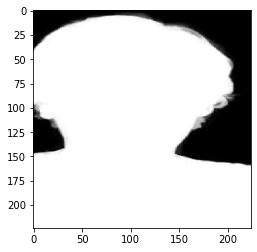

In [31]:
label_numpy = labels.numpy()[0,:,:,1]
print(label_numpy.shape)
plt.imshow(label_numpy, cmap="gray")

## 2.创建model

In [13]:
# step2： 创建model
model = Unet(inputs_size, num_classes)  # 需要传入输入大小和最终输出通道数
model.load_weights(model_path, by_name=True, skip_mismatch=True)  # 加载预训练模型

In [14]:
# step3：创建loss及优化器
loss = CE()
lr_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps=epoch_size,decay_rate=decay_rate, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

In [15]:
# step4：迭代训练
for epoch in range(max_epoch):
    fit_one_epoch(model, loss, optimizer, epoch, epoch_size, epoch_size_val, gen, gen_val, max_epoch, get_train_step_fn())
    path_model = os.path.join(log_dir, "model_weight_{}.h5".format(time_str))
    model.save_weights(path_model)
    print("Epoch:{}, model save at :{}".format(epoch, path_model))

Epoch 1/100:   1%|          | 13/1800 [00:05<11:48,  2.52it/s, Total Loss=2.17, Total f_score=0.344, lr=1e-04] 


KeyboardInterrupt: 